### Data Dictionary-Aligned Analysis: Resolving Schema Discrepancies

---


As part of our two-pronged approach to analyzing factors affecting delivery delays in the U.S. supply chain, this version of the dataset reflects the second approach, where we modified the data to match the provided documentation. In our first approach, we analyzed the dataset in its raw form. However, discrepancies were noted between the documented descriptions and the actual values—for instance, categorical variables like order fulfillment status, handling equipment availability, and cargo condition status appeared as continuous decimal values instead of binary indicators. In this cleaned version, we corrected these inconsistencies by converting affected fields to their appropriate categorical formats (e.g., 0 = not fulfilled, 1 = fulfilled) as per the official feature definitions. Additionally, we rounded all long decimal values to two decimal places to improve clarity and uniformity.

### 1. Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau
from IPython.display import display

### 2. Load Cleaned Dataset

In [2]:
df = pd.read_csv("cleaned_secondApproach_dataset.csv")

### 3. Define ETA Status (Early, On-Time, Late)

In [3]:
# Define variables
features = [
    "traffic_congestion_level",
    "warehouse_inventory_level",
    "loading_unloading_time",
    "handling_equipment_availability",
    "weather_condition_severity",
    "port_congestion_level",
    "shipping_costs",
    "supplier_reliability_score",
    "lead_time_days",
    "historical_demand",
    "iot_temperature",
    "cargo_condition_status",
    "route_risk_level",
    "customs_clearance_time",
    "driver_behavior_score",
    "fatigue_monitoring_score",
]
targets = ["delay_probability", "delivery_time_deviation", "eta_variation_hours"]

This classification uses ±0.5 hours as the tolerance window for 'On-Time' deliveries.

### 4. Plot ETA Status Distribution

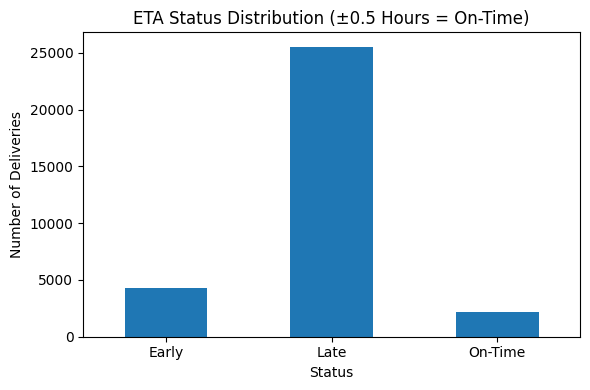

In [4]:
# Reclassify ETA_Status: only exact 0.00 as "On-Time"
df = df.copy()


# Reclassify ETA_Status using ±0.5 hour window as "On-Time"
def classify_eta_loose(val):
    if val < -0.5:
        return "Early"
    elif val > 0.5:
        return "Late"
    else:
        return "On-Time"


# Apply classification
df["ETA_Status"] = df["eta_variation_hours"].apply(classify_eta_loose)
eta_counts_loose = df["ETA_Status"].value_counts().sort_index()

# Plot updated distribution
plt.figure(figsize=(6, 4))
eta_counts_loose.plot(kind="bar")
plt.title("ETA Status Distribution (±0.5 Hours = On-Time)")
plt.xlabel("Status")
plt.ylabel("Number of Deliveries")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The bar chart shows how many deliveries were classified as Early, On-Time, or Late based on ETA variation.
This plot shows the distribution of delivery ETA status with 'On-Time' defined as within ±0.5 hours.

C:\Users\HP\AppData\Local\Temp\ipykernel_25632\3568570085.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df["eta_variation_hours"].resample("M").mean()


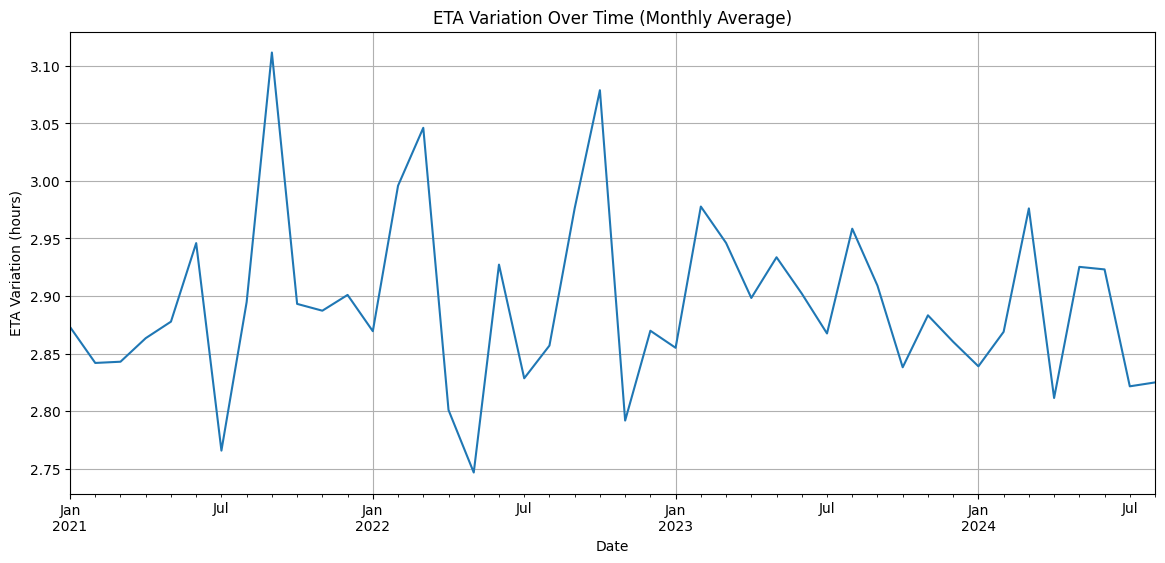

In [5]:
# Load data

# Convert 'timestamp' to datetime and set as index
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")

df_resampled = df["eta_variation_hours"].resample("M").mean()

plt.figure(figsize=(14, 6))
df_resampled.plot()
plt.title("ETA Variation Over Time (Monthly Average)")
plt.ylabel("ETA Variation (hours)")
plt.xlabel("Date")
plt.grid(True)
plt.show()

### 5. Pearson Correlation for Interaction Features vs Target Variables

In [6]:
# Define features and targets again
features = [
    "route_risk_level",
    "port_congestion_level",
    "warehouse_inventory_level",
    "historical_demand",
    "fatigue_monitoring_score",
    "handling_equipment_availability",
    "driver_behavior_score",
    "traffic_congestion_level",
    "shipping_costs",
    "iot_temperature",
    "customs_clearance_time",
    "cargo_condition_status",
    "weather_condition_severity",
    "loading_unloading_time",
    "supplier_reliability_score",
    "lead_time_days",
]

targets = ["eta_variation_hours", "delay_probability", "delivery_time_deviation"]

# Calculate Pearson correlation and store results in DataFrame
result_table = []

for target in targets:
    for feature in features:
        try:
            corr, _ = pearsonr(df[feature], df[target])
            result_table.append(
                {"Target": target, "Feature": feature, "Pearson Correlation": corr}
            )
        except Exception as e:
            result_table.append(
                {
                    "Target": target,
                    "Feature": feature,
                    "Pearson Correlation": None,
                    "Error": str(e),
                }
            )

# Convert to DataFrame
pearson_df = pd.DataFrame(result_table)

# Sort by absolute correlation value for each target
pearson_df["abs_corr"] = pearson_df["Pearson Correlation"].fillna(0).abs()
pearson_df = pearson_df.sort_values(
    by=["Target", "abs_corr"], ascending=[True, False]
).drop(columns="abs_corr")

# Show to user
display(pearson_df)

,Target,Feature,Pearson Correlation
17,delay_probability,port_congestion_level,0.008895
26,delay_probability,customs_clearance_time,0.004840
21,delay_probability,handling_equipment_availability,0.004708
18,delay_probability,warehouse_inventory_level,0.004563
22,delay_probability,driver_behavior_score,-0.003881
23,delay_probability,traffic_congestion_level,-0.003824
16,delay_probability,route_risk_level,-0.003366
19,delay_probability,historical_demand,-0.002913
30,delay_probability,supplier_reliability_score,0.001856
28,delay_probability,weather_condition_severity,0.001500


This table summarizes the Pearson correlation between each feature and all target variables.

### 8. Calculate Pearson Correlations with Selected Features

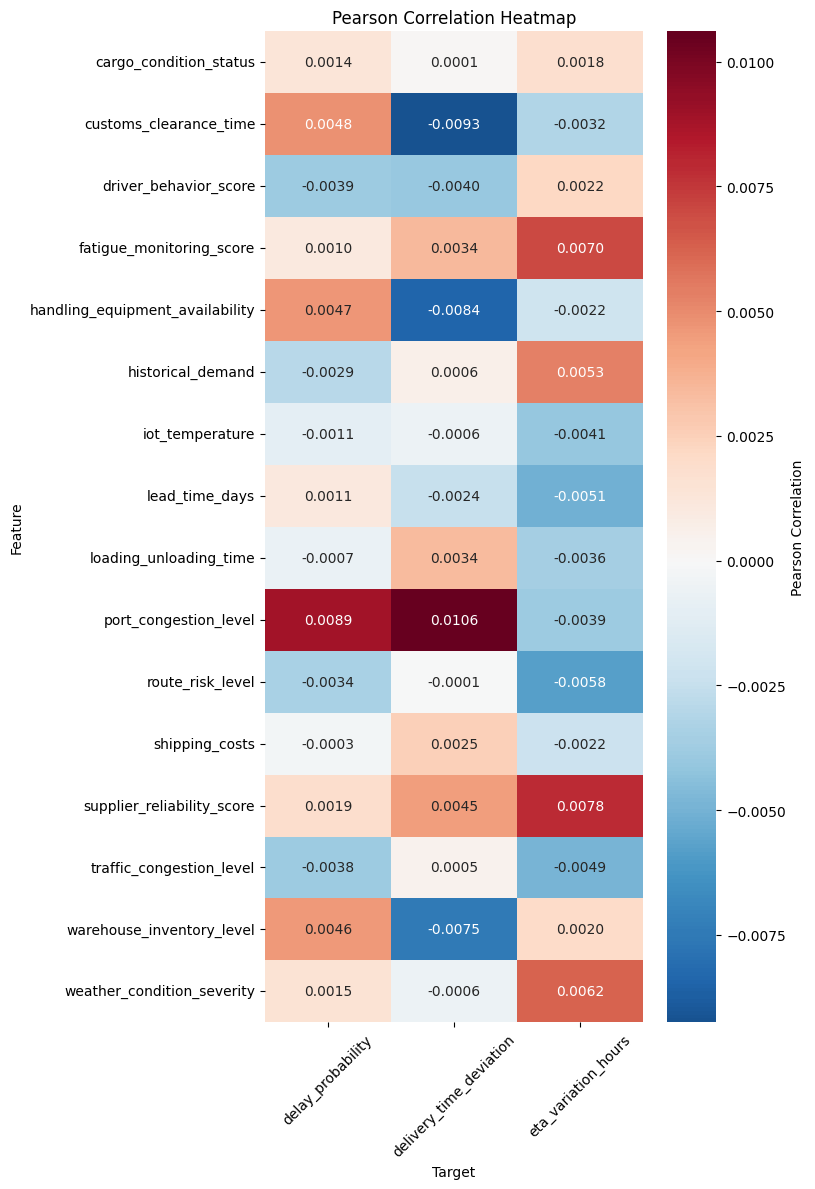

In [7]:
# Create Pearson heatmap
data = []
for index, row in pearson_df.iterrows():
    data.append(
        {
            "Feature": row["Feature"],
            "Target": row["Target"],
            "Correlation": row["Pearson Correlation"],
        }
    )


df_pearson = pd.DataFrame(data)
pivot_pearson = df_pearson.pivot(
    index="Feature", columns="Target", values="Correlation"
)

plt.figure(figsize=(8, 12))
sns.heatmap(
    pivot_pearson,
    annot=True,
    cmap="RdBu_r",
    center=0,
    fmt=".4f",
    cbar_kws={"label": "Pearson Correlation"},
)
plt.title("Pearson Correlation Heatmap")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 9. Display Spearman Correlation Results in Table Format

In [8]:
# Define features and targets (ensure they are defined)
features = [
    "route_risk_level",
    "port_congestion_level",
    "warehouse_inventory_level",
    "historical_demand",
    "fatigue_monitoring_score",
    "handling_equipment_availability",
    "driver_behavior_score",
    "traffic_congestion_level",
    "shipping_costs",
    "iot_temperature",
    "customs_clearance_time",
    "cargo_condition_status",
    "weather_condition_severity",
    "loading_unloading_time",
    "supplier_reliability_score",
    "lead_time_days",
]

targets = ["eta_variation_hours", "delay_probability", "delivery_time_deviation"]


# Calculate Spearman correlation and store results in DataFrame
spearman_table = []

for target in targets:
    for feature in features:
        try:
            corr, _ = spearmanr(df[feature], df[target])
            spearman_table.append(
                {"Target": target, "Feature": feature, "Spearman Correlation": corr}
            )
        except Exception as e:
            spearman_table.append(
                {
                    "Target": target,
                    "Feature": feature,
                    "Spearman Correlation": None,
                    "Error": str(e),
                }
            )

# Convert to DataFrame
spearman_df = pd.DataFrame(spearman_table)

# Sort by absolute correlation value for each target
spearman_df["abs_corr"] = spearman_df["Spearman Correlation"].fillna(0).abs()
spearman_df = spearman_df.sort_values(
    by=["Target", "abs_corr"], ascending=[True, False]
).drop(columns="abs_corr")

# Show to user
display(spearman_df)

,Target,Feature,Spearman Correlation
16,delay_probability,route_risk_level,-0.006458
17,delay_probability,port_congestion_level,0.006251
18,delay_probability,warehouse_inventory_level,0.006092
19,delay_probability,historical_demand,-0.005525
20,delay_probability,fatigue_monitoring_score,0.004693
22,delay_probability,driver_behavior_score,-0.003825
23,delay_probability,traffic_congestion_level,-0.003484
21,delay_probability,handling_equipment_availability,0.003452
24,delay_probability,shipping_costs,-0.002468
25,delay_probability,iot_temperature,0.002161


This table shows the Spearman rank-order correlation for feature-target relationships.

### 10. Calculate Spearman Correlations with Selected Features

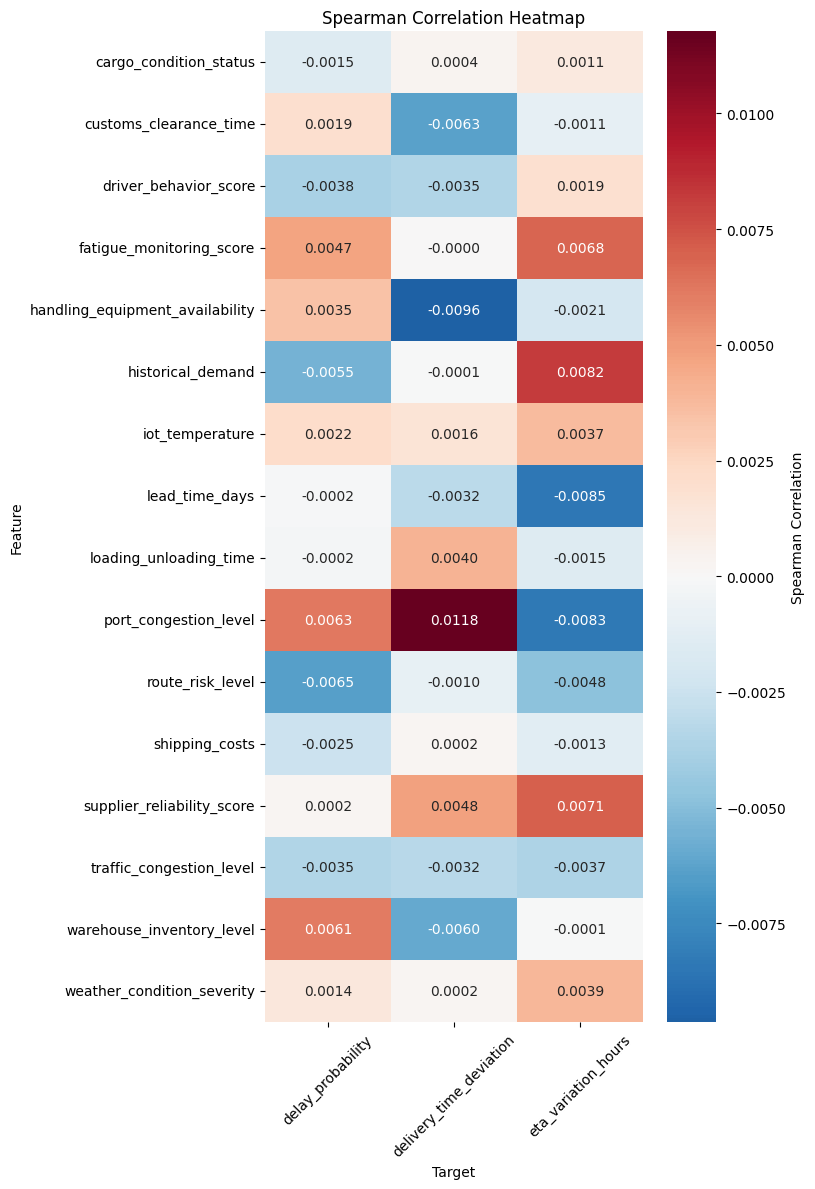

In [9]:
# Create spearman heatmap
data = []
for index, row in spearman_df.iterrows():
    data.append(
        {
            "Feature": row["Feature"],
            "Target": row["Target"],
            "Correlation": row["Spearman Correlation"],
        }
    )

df_spearman = pd.DataFrame(data)
pivot_spearman = df_spearman.pivot(
    index="Feature", columns="Target", values="Correlation"
)

plt.figure(figsize=(8, 12))
sns.heatmap(
    pivot_spearman,
    annot=True,
    cmap="RdBu_r",
    center=0,
    fmt=".4f",
    cbar_kws={"label": "Spearman Correlation"},
)
plt.title("Spearman Correlation Heatmap")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This table presents Kendall Tau correlations, a non-parametric measure of ordinal association.

### 12. Calculate Kendall Tau Correlation in Table format

In [10]:
# Calculate Kendall Tau correlation and store results in DataFrame
kendall_table = []

for target in targets:
    for feature in features:
        try:
            corr, _ = kendalltau(df[feature], df[target])
            kendall_table.append(
                {"Target": target, "Feature": feature, "Kendall Correlation": corr}
            )
        except Exception as e:
            kendall_table.append(
                {
                    "Target": target,
                    "Feature": feature,
                    "Kendall Correlation": None,
                    "Error": str(e),
                }
            )

# Convert to DataFrame
kendall_df = pd.DataFrame(kendall_table)

# Sort by absolute correlation value for each target
kendall_df["abs_corr"] = kendall_df["Kendall Correlation"].abs()
kendall_df = kendall_df.sort_values(
    by=["Target", "abs_corr"], ascending=[True, False]
).drop(columns="abs_corr")

# Show to user
display(kendall_df)

,Target,Feature,Kendall Correlation
16,delay_probability,route_risk_level,-0.004395
17,delay_probability,port_congestion_level,0.004265
18,delay_probability,warehouse_inventory_level,0.004167
19,delay_probability,historical_demand,-0.003753
20,delay_probability,fatigue_monitoring_score,0.003223
21,delay_probability,handling_equipment_availability,0.002872
22,delay_probability,driver_behavior_score,-0.002602
23,delay_probability,traffic_congestion_level,-0.002356
24,delay_probability,shipping_costs,-0.001663
25,delay_probability,iot_temperature,0.001490


The heatmap shows how pairwise interactions between features relate to ETA variation, delay probability, and delivery deviation.

### 14. Kendall's Tau Correlation

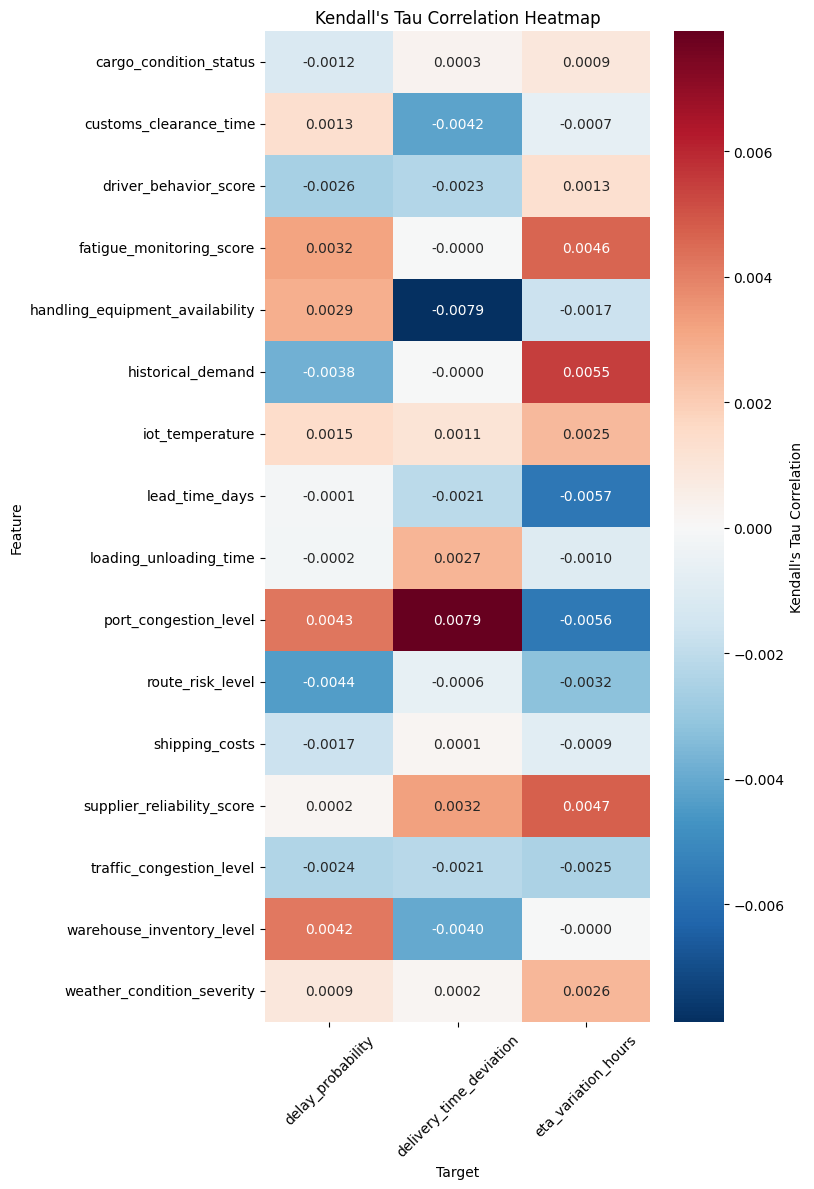

In [11]:
data = []
for index, row in kendall_df.iterrows():
    data.append(
        {
            "Feature": row["Feature"],
            "Target": row["Target"],
            "Correlation": row["Kendall Correlation"],
        }
    )

df_kendall = pd.DataFrame(data)
pivot_kendall = df_kendall.pivot(
    index="Feature", columns="Target", values="Correlation"
)

plt.figure(figsize=(8, 12))
sns.heatmap(
    pivot_kendall,
    annot=True,
    cmap="RdBu_r",
    center=0,
    fmt=".4f",
    cbar_kws={"label": "Kendall's Tau Correlation"},
)
plt.title("Kendall's Tau Correlation Heatmap")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Only the most impactful interactions are kept based on their maximum correlation with any target.

### 15. Scatter Plots of Top Interaction Features vs Target Variables

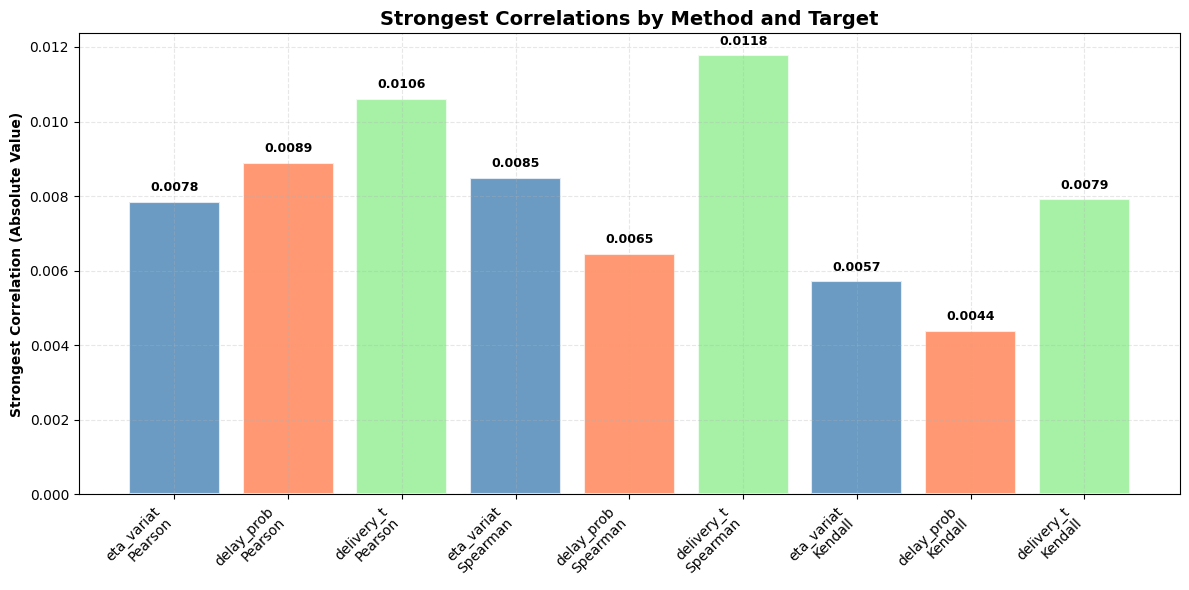


Top correlations:
ETA_VARIATION_HOURS: P:0.0078 | S:0.0085 | K:0.0057
DELAY_PROBABILITY: P:0.0089 | S:0.0065 | K:0.0044
DELIVERY_TIME_DEVIATION: P:0.0106 | S:0.0118 | K:0.0079


In [12]:
# bar chart comparison of strongest correlations
# Extract data and create enhanced visualization
data = []

# Get strongest Pearson correlations
for target in targets:
    strongest_pearson = pearson_df[pearson_df["Target"] == target].iloc[0]
    data.append(
        (abs(strongest_pearson["Pearson Correlation"]), f"{target[:10]}\nPearson")
    )

# Get strongest Spearman correlations
for target in targets:
    strongest_spearman = spearman_df[spearman_df["Target"] == target].iloc[0]
    data.append(
        (abs(strongest_spearman["Spearman Correlation"]), f"{target[:10]}\nSpearman")
    )

# Get strongest Kendall correlations
for target in targets:
    strongest_kendall = kendall_df[kendall_df["Target"] == target].iloc[0]
    data.append(
        (abs(strongest_kendall["Kendall Correlation"]), f"{target[:10]}\nKendall")
    )


corrs, labels = zip(*data)
colors = ["steelblue", "coral", "lightgreen"] * len(targets)

plt.figure(figsize=(12, 6))
bars = plt.bar(
    range(len(corrs)), corrs, color=colors, alpha=0.8, edgecolor="white", linewidth=1.5
)

plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.ylabel("Strongest Correlation (Absolute Value)", fontweight="bold")
plt.title("Strongest Correlations by Method and Target", fontsize=14, fontweight="bold")
plt.grid(True, alpha=0.3, linestyle="--")

# Add value labels
for bar, corr in zip(bars, corrs):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.0002,
        f"{corr:.4f}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

# summary
print("\nTop correlations:")
for target in targets:
    print(
        f"{target.upper()}: P:{abs(pearson_df[pearson_df['Target'] == target].iloc[0]['Pearson Correlation']):.4f} | "
        f"S:{abs(spearman_df[spearman_df['Target'] == target].iloc[0]['Spearman Correlation']):.4f} | "
        f"K:{abs(kendall_df[kendall_df['Target'] == target].iloc[0]['Kendall Correlation']):.4f}"
    )

These scatter plots illustrate the relationships between the top interaction terms and each target variable.

### 16. Correlation of Interaction features with Target Varibales

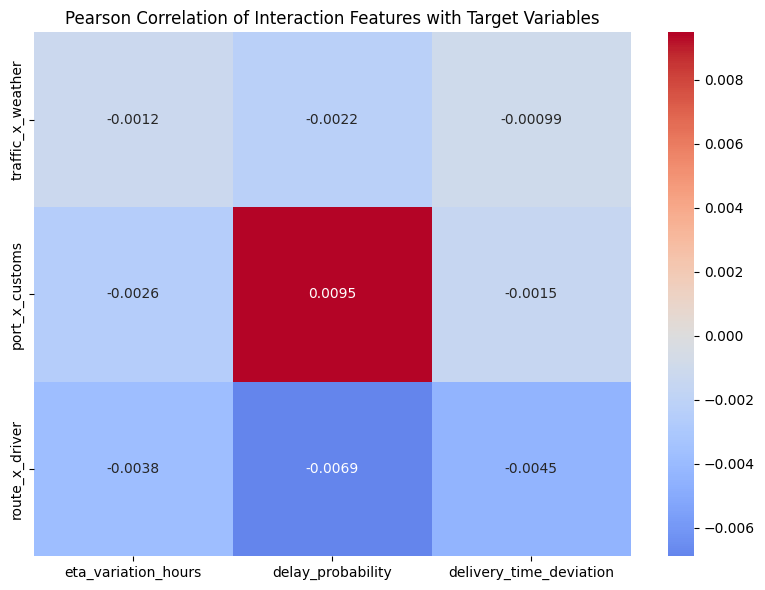

In [13]:
# Create interaction features
df["traffic_x_weather"] = (
    df["traffic_congestion_level"] * df["weather_condition_severity"]
)
df["port_x_customs"] = df["port_congestion_level"] * df["customs_clearance_time"]
df["route_x_driver"] = df["route_risk_level"] * df["driver_behavior_score"]

# Define features and targets
interaction_features = ["traffic_x_weather", "port_x_customs", "route_x_driver"]
targets = ["eta_variation_hours", "delay_probability", "delivery_time_deviation"]

# Combine into one DataFrame for correlation
corr_df = df[interaction_features + targets]

# Compute Pearson correlation matrix
correlation_matrix = corr_df.corr(method="pearson")

# Subset: correlation of interaction features vs. targets
correlation_subset = correlation_matrix.loc[interaction_features, targets]

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_subset, annot=True, cmap="coolwarm", center=0)
plt.title("Pearson Correlation of Interaction Features with Target Variables")
plt.tight_layout()
plt.show()